# Multi-class Classification: Neural Networks

This notebook contains the Programming Exercise 4 of the Andrew Ng's course on Coursera.

Implement a multi-class classification model using Neural Networks to recognize handwritten numbers (0-9). In addition to the Forward Propagation already implemented in exercise 3, we will add the Backpropagation algorithm to complete the NN model.

The NN has 3 levels:
- L1: 401 = 400 (20x20) features + 1 bias
- L2: 25 + 1 bias
- L3: 10 classification labels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data
Same as previous exercise with Logistic Regression Classifier

In [4]:
# Load the data (in .mat format)
from scipy.io import loadmat
data = loadmat('ex3data1.mat')

X = data['X']
y = data['y']
X.shape, y.shape

((5000, 400), (5000, 1))

## Visualize data

Load the helper functions to visualize a 10x10 matrix of handwritten numbers

In [5]:
# Helper functions to visualize the data (from https://github.com/kaleko/CourseraML/blob/master/ex3/ex3.ipynb)

import scipy.misc #Used to show matrix as an image
import random #To pick random images to display
import matplotlib.cm as cm #Used to display images in a specific colormap

def getDatumImg(row):
    # Function that is handed a single np array with shape 1x400, creates an image object from it, and returns it
    width, height = 20, 20
    square = row[0:].reshape(width,height)
    return square.T

def displayData(indices_to_display = None):
    # Function that picks 100 random rows from X, creates a 20x20 image from each, then stitches them together into a 10x10 grid of images, and shows it
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

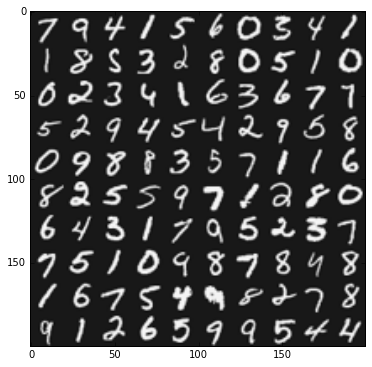

In [10]:
# print a random sample of numbers
displayData()

## One-hot encoding of 'y'

We need to one-hot encode our y labales. Rights now y is a [5000x1] array where each element contains a number in the range (1...10) that represents the handwritten number of the corresponding training sample (note the '10' represents the '0').

With a one-hot encoding we transform each element of y into an array with 10 elements where each one is a binary representation of each label. This way, a sample labeled as '3' will have the 3rd bit hot ('1') and the rest 'cold' (0).

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [15]:
y[3245], y_onehot[3245]

(array([6], dtype=uint8),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]))

## Cost Computation (Forward propagation)

Let's first implement the functions that are required to implement the cost.

The cost function evaluates how a given set of parameters theta represents a good model. To compute the cost we inject the input features X to the network and apply the Forward Propagation algorithm to obtain the predicted classifications (h). The cost function summarizes the differences between the predicted and the real classifications.

In [16]:
# sigmoid function definition
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [18]:
# Function that receives as input:
#   - X[ num_samples x num_features ]
#   - theta1[ num_L2_units_no_bias x (num_features+1) ]
#   - theta2[ num_output_labels x num_L2_units_with_bias ]
# and returns:
#   - all the forward propagation steps
#     - a1 [ num_samples x (num_features+1) ]
#     - z2 [ num_samples x num_L2_units_no_bias ]
#     - a2 [ num_samples x num_L2_units_with_bias ]
#     - z3 [ num_samples x num_output_labels ]
#     - h  [ num_samples x num_output_labels ]
def forward_propagate(X, theta1, theta2):
    
    # convert to matrices to use notation of algebra operations
    X = np.matrix(X)
    theta1 = np.matrix(theta1)
    theta2 = np.matrix(theta2)
    
    # set helper variable
    num_features = X.shape[0]
    
    # add the bias unit at Level 1 (a1 is a vector of [num_samplesx401])
    a1 = np.insert(X, 0, values=np.ones(num_features), axis=1)
    
    # Compute z2 (a1[1x401] · theta1.T[401x25] = z2[1x25])
    z2 = a1 * theta1.T
    
    # Compute a2, and add the bias unit at Level 2 (a2 is a vector of [num_samplesx26])
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(num_features), axis=1)
    
    # Compute z3 (a2[num_samplesx26] · theta2.T[26x10] = z2[num_samplesx10])
    z3 = a2 * theta2.T

    # Compute h (or a3) (h is a vector of [num_samplesx10])
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

In [72]:
# Function that receives as input:
#   - X[ num_samples x num_features ]
#   - y[ num_samples x num_labels ] (one-hot encoded)
#   - theta1[ num_L2_units_no_bias x (num_features+1) ]
#   - theta2[ num_output_labels_ x num_L2_units_with_bias ]
#   - learning_rate (scalar for the regularization term)
# and returns: 
#   - the computed cost J
def cost(X, y, theta1, theta2, learning_rate):
    
    m = X.shape[0]
    
    # convert to matrices to use notation of algebra operations
    X = np.matrix(X)
    y = np.matrix(y)
    theta1 = np.matrix(theta1)
    theta2 = np.matrix(theta2)
    
    # run the (vectorized) forward propagation
    #     - a1 [ num_samples x (num_features+1) ]
    #     - z2 [ num_samples x num_L2_units_no_bias ]
    #     - a2 [ num_samples x num_L2_units_with_bias ]
    #     - z3 [ num_samples x num_output_labels ]
    #     - h  [ num_samples x num_output_labels ]
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute cost (without regularization)
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    J = J / m
    
    # add the regularization term
    regularization_theta1 = np.sum(np.power(theta1[:,1:], 2))
    regularization_theta2 = np.sum(np.power(theta2[:,1:], 2))
    J += (float(learning_rate) / (2 * m)) * (regularization_theta1 + regularization_theta2)
    
    return J

## Test the cost calculation: random theta

Let's quickly test this cost function calculation with a set of random theta parameters

In [87]:
# randomly initialize a the theta parameters arrays
#   - theta1[ num_L2_units_no_bias x (num_features+1) ]
#   - theta2[ num_output_labels x num_L2_units_with_bias ]
theta1_temp = (np.random.random(size=25*(400+1)) - 0.5) * 0.25
theta1      = np.reshape(theta1_temp[:25*(400+1)],(25,(400+1)))
theta2_temp = (np.random.random(size=10*(25+1)) - 0.5) * 0.25
theta2      = np.reshape(theta2_temp[:10*(25+1)],(10,(25+1)))
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [88]:
# Now let's compute the cost
cost(X, y_onehot, theta1, theta2, 0)

6.7181262382422586

In [89]:
# Now let's compute the cost
cost(X, y_onehot, theta1, theta2, 1)

6.7233952475771517

Well, at least it didn't crash, and the cost is always around 6-7. But I have no way to check whether this cost is correct or not...

## Test the cost calculation: precomputed theta

Let's quickly test this cost function calculation with a set of random theta parameters

In [81]:
from scipy.io import loadmat
thetas = loadmat('ex3weights.mat')
theta1, theta2 = thetas['Theta1'], thetas['Theta2']

In [82]:
# Now let's compute the cost
cost(X, y_onehot, theta1, theta2, 0)

0.2876291651613187

In [85]:
# Now let's compute the cost
cost(X, y_onehot, theta1, theta2, 1)

0.38376985909092343

This looks better... Much lower cost compared to random initialization of thetas